# Moment curvature

Introduction to `sympy`, `numpy` and `scipy` showing how to write
semi-analytical models for the reinforced cross-sectional
combinations.

This notebook starts with the basic expressions for bending.

## Import modules

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
sp.init_printing()

In [2]:
from scipy.optimize import newton, brentq, root

Introduce the cross sectional curvature $\kappa$ which is equal to
\begin{align}
\kappa = \frac{\partial \varepsilon_{xx}}{\partial z}
\end{align}

**Cross sectional parameters**

In [3]:
b, h = sp.symbols('b, h', nonnegative = True ) 

In [4]:
kappa = sp.Symbol('kappa', real=True, nonpositive=True)

**Parameters of the constitutive law**

In [5]:
E_ct, E_cc, eps_cr, eps_fail, sigma_pc = sp.symbols(
    r'E_ct, E_cc, varepsilon_cr, varepsilon_fail, sigma_pc', 
    real=True, nonnegative=True
)

In [6]:
eps_yield, eps_c_fail = sp.symbols(
    r'varepsilon_y, eps_c_fail', real=True, nonpositive=True
)

**Linear profile** of strain over the height

In [7]:
eps_top = sp.symbols(
    'varepsilon_top', real=True, nonpositive=True )
eps_bot = sp.symbols(
    'varepsilon_bot', real=True, nonnegative=True )
z = sp.symbols('z', nonnegative = True )

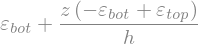

In [8]:
eps_z = eps_bot + z * (eps_top - eps_bot) / h
eps_z

## Constitutive law

In [9]:
eps = sp.Symbol('varepsilon', real=True )

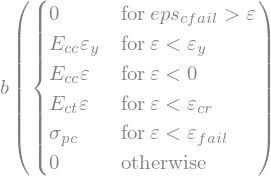

In [11]:
sig = b * sp.Piecewise(
    (0, eps < eps_c_fail),
    (E_cc * eps_yield, eps < eps_yield),
    (E_cc * eps, eps < 0), 
    (E_ct * eps, eps < eps_cr),
    (sigma_pc, eps < eps_fail),
    (0, eps >= eps_fail)
)
sig

**Define the material data:**

In [12]:
model_data = {
    b : 50,
    h : 100,
    E_ct : 24000, E_cc : 25000, 
    eps_cr : 0.001, 
    eps_yield:-0.003, 
    eps_c_fail:-0.01, 
    sigma_pc:10,
    eps_fail : 0.003
}

Hint - use the param tuple with conversion utilities to generate the `get_function`

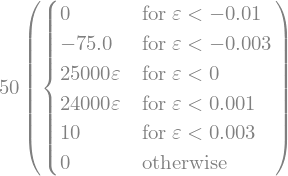

In [13]:
sig.subs(model_data)

In [14]:
get_sig_eps = sp.lambdify(eps, sig.subs(model_data), 'numpy' )

**Plot the material behavior**

In [ ]:
eps_min, eps_max = -0.012, 0.005
fig, ax1 = plt.subplots(1,1, figsize=(8,3.5)) 
eps_data = np.linspace(eps_min, eps_max, 1000)
ax1.plot(eps_data, get_sig_eps(eps_data),color='black')
ax1.fill_between(eps_data, get_sig_eps(eps_data),color='black', alpha=0.1)
ax1.set_xlabel(r'$\varepsilon\;\;\mathrm{[mm]}$'); ax1.set_ylabel(r'$\sigma\;\;\mathrm{[MPa]}$'); 
ax1.set_title('concrete behhavior');

**Stress over the cross section**

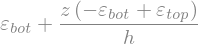

In [15]:
eps_z

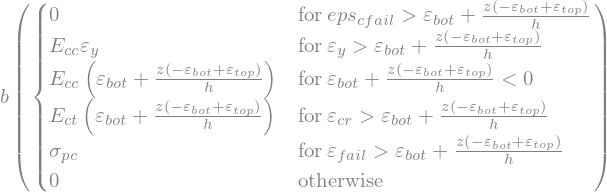

In [16]:
sig_z = sig.subs(eps, eps_z)
sig_z

Express $\varepsilon_\mathrm{top}$ as a function of $\kappa$ and $\varepsilon_\mathrm{bot}$

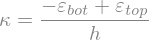

In [19]:
kappa_eq_ = sp.Eq(kappa, eps_z.diff(z))
kappa_eq_

In [20]:
eps_top_solved_ = sp.solve(kappa_eq_, eps_top)[0]
eps_top_solved_

In [21]:
subs_eps_top_ = {eps_top : eps_top_solved_}
subs_eps_top_

In [22]:
eps_z.subs(subs_eps_top_)

In [ ]:
get_eps_z = sp.lambdify(
    (kappa, eps_bot, z), eps_z.subs(subs_eps_top_), 'numpy'
)

Use the substitution in expression of stresses over the height

In [ ]:
sig_z_lin = sig_z.subs(subs_eps_top_)
sig_z_lin

# Reinforcement bar
Define a position of a bar $z_i$ with associated area $A_i$ and E-Modulus $E_i$.

In [ ]:
z_i = np.array([10], dtype=np.float_)
A_i = np.array([[np.pi * (16/2.)**2]], dtype=np.float_)
E_i = np.array([[210000]], dtype=np.float_)

# Model data

In [ ]:
model_data

In [ ]:
sig_z_lin.subs(model_data)

In [ ]:
get_sig_z = sp.lambdify(
    (kappa, eps_bot, z), sig_z_lin.subs(model_data), 'numpy'
)

# Stress resultants

In [ ]:
z_arr = np.linspace(0, 100, 100)

In [ ]:
def get_N_s(kappa, eps_bot):
    eps_z_i = get_eps_z(
        kappa[:,np.newaxis], eps_bot[:,np.newaxis], z_i[np.newaxis,:], 
    )
    N_s = np.sum(E_i * A_i * eps_z_i, axis=-1)
    print(E_i, A_i, eps_z_i)
    return N_s

def get_N_c(kappa, eps_bot, get_sig_z=get_sig_z):
    zz_arr = z_arr[np.newaxis,:]
    sig_z_arr = get_sig_z(kappa[:,np.newaxis], eps_bot[:,np.newaxis], 
                          zz_arr)
    return np.trapz(sig_z_arr, x=zz_arr, axis=-1 )

def get_N(phi, eps_bot, get_sig_z=get_sig_z):
    return get_N_c(phi, eps_bot, get_sig_z) + get_N_s(phi, eps_bot)

In [ ]:
get_eps_z(np.array([0.01]), np.array([0.01]), np.array([10]))

In [ ]:
def get_M_s(kappa, eps_bot):
    eps_z_i = get_eps_z(
        kappa[:,np.newaxis], eps_bot[:,np.newaxis], z_i[np.newaxis,:], 
    )
    return np.sum((E_i * A_i * eps_z_i) * z_i, axis=-1)
    
def get_M_c(kappa, eps_bot):
    zz_arr = z_arr[np.newaxis,:]
    sig_z_arr = get_sig_z(kappa[:,np.newaxis], eps_bot[:,np.newaxis], 
                          zz_arr)
    return np.trapz(sig_z_arr*zz_arr, x=zz_arr, axis=-1 )

def get_M(kappa, eps_bot):
    return get_M_c(kappa, eps_bot) + get_M_s(kappa, eps_bot)

# Solution procedure
ind strain $\varepsilon_\mathrm{bot}$ that renders zero normal force $N = 0$ for a given $\kappa$ 

In [ ]:
def get_eps_bot( kappa ):
    res = root( lambda eps_bot: get_N(kappa, eps_bot), 
                  np.zeros_like(kappa), tol=1e-10 )
    return res.x

In [ ]:
def get_eps_bot( kappa ):
    eps_bot_0 = np.zeros_like(kappa)

    def get_N_iter(eps_bot):
        return get_N(kappa, eps_bot)
    
    res = root( get_N_iter, eps_bot_0, tol=1e-10)
    return res.x

**Define range of curvatures**

In [ ]:
kappa_arr = np.linspace(-0.001,0.001,101)

In [ ]:
eps_z_arr = get_eps_z(
    kappa_arr[:,np.newaxis], eps_bot_arr[:,np.newaxis], z_arr[np.newaxis,:],
)
sig_z_arr = get_sig_z(
    kappa_arr[:,np.newaxis], eps_bot_arr[:,np.newaxis], z_arr[np.newaxis,:], 
)

In [ ]:
M_arr = get_M(kappa_arr, eps_bot_arr)

In [ ]:
idx = 8
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(8,5))
ax1.plot(kappa_arr, M_arr)
ax1.plot(kappa_arr[idx], M_arr[idx], marker='o')
ax2.plot(eps_z_arr[idx,:], z_arr, color='red', label=r'\varepsilon');
#ax2.fill_between(eps_z_arr[idx,:], z_arr, 0, alpha=0.1);
ax3 = ax2.twiny()
ax3.plot(sig_z_arr[idx,:], z_arr);
#ax3.fill_between(sig_z_arr[idx,:], z_arr, 0, alpha=0.1);

# Class maintaining state and dependencies

In [ ]:
import traits.api as tr

In [ ]:
class MomentCurvature(tr.HasStrictTraits):
    r'''Class returning the moment curvature relationship.
    '''
    model_params = tr.Dict({
        b : 50,
        h : 100,
        E_ct : 24000, E_cc : 25000, 
        eps_cr : 0.001, 
        eps_yield:-0.003, 
        eps_c_fail:-0.01, 
        sigma_pc:10,
        eps_fail : 0.003
    })
    
    # Reinforcement
    z_i = tr.Array(np.float_, value=[10])
    A_i = tr.Array(np.float_, value=[[np.pi * (16/2.)**2]])
    E_i = tr.Array(np.float_, value=[[210000]])
    
    z_arr = tr.Property(depends_on='model_params_items')
    @tr.cached_property
    def _get_z_arr(self):
        return np.linspace(0,self.model_params[h],100)

    kappa_range = tr.Tuple(-0.001,0.001,101)
    
    kappa = tr.Property( tr.Array(np.float_), depends_on='kappa_range' )
    @tr.cached_property
    def _get_kappa(self):
        return np.linspace(*self.kappa_range)

    get_eps_z = tr.Property(depends_on='model_params_items')
    @tr.cached_property
    def _get_get_eps_z(self):
        return sp.lambdify(
            (kappa, eps_bot, z), eps_z.subs(subs_eps), 'numpy'
        )
    
    get_sig_z = tr.Property(depends_on='model_params_items')
    @tr.cached_property
    def _get_get_sig_z(self):
        return sp.lambdify(
            (kappa, eps_bot, z), sig_z_lin.subs(self.model_params), 'numpy'
        )
    
    # Normal force
    def get_N_s(self, kappa, eps_bot):
        eps_z_i = get_eps_z(
            kappa[:,np.newaxis], eps_bot[:,np.newaxis], self.z_i[np.newaxis,:], 
        )
        return np.sum(self.E_i * self.A_i * eps_z_i, axis=-1)

    def get_N_c(self, kappa, eps_bot):
        zz_arr = self.z_arr[np.newaxis,:]
        sig_z_arr = self.get_sig_z(kappa[:,np.newaxis], eps_bot[:,np.newaxis], 
                                  zz_arr)
        return np.trapz(sig_z_arr, x=zz_arr, axis=-1 )

    def get_N(self, kappa, eps_bot):
        return get_N_c(kappa, eps_bot) + get_N_s(kappa, eps_bot)    
 
    eps_bot = tr.Property()
    r'''Resolve the tensile strain to get zero normal force 
    for the prescribed curvature
    '''
    def _get_eps_bot( self ):
        res = root( lambda eps_bot: self.get_N(self.kappa, eps_bot), 
                      np.zeros_like(self.kappa), tol=1e-10 )
        return res.x 
    
    M_s = tr.Property()
    def _get_M_s(self):
        eps_z_i = self.get_eps_z(
            self.kappa[:,np.newaxis], self.eps_bot[:,np.newaxis], 
            self.z_i[np.newaxis,:], 
        )
        return np.sum((self.E_i * self.A_i * eps_z_i) * self.z_i, axis=-1)

    M_c = tr.Property()
    def _get_M_c(self):
        zz_arr = self.z_arr[np.newaxis,:]
        sig_z_arr = self.get_sig_z(
            self.kappa[:,np.newaxis], self.eps_bot[:,np.newaxis], zz_arr)
        return np.trapz(sig_z_arr*zz_arr, x=zz_arr, axis=-1 )

    M_arr = tr.Property()
    def _get_M_arr(self):
        return self.M_c + self.M_s
    
    eps_z_arr = tr.Property()
    def _get_eps_z_arr(self):
        return get_eps_z(
            self.kappa[:,np.newaxis], self.eps_bot[:,np.newaxis], 
            self.z_arr[np.newaxis,:],
        )
    
    sig_z_arr = tr.Property()
    def _get_sig_z_arr(self):
        return get_sig_z(
            self.kappa[:,np.newaxis], self.eps_bot[:,np.newaxis], 
            self.z_arr[np.newaxis,:], 
        )
    
    def get_kappa(self, M):
        # cut off the descending tails
        I_M = np.where(self.M_arr[1:] - self.M_arr[:-1] > 0)
        M_I = self.M_arr[I_M]
        kappa_I = self.kappa_arr[I_M]
        return np.interp(M, M_I, kappa_I)
        
    idx = tr.Int(0)
    def plot(self):
        idx = self.idx
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,5))
        ax1.plot(self.kappa, self.M_arr)
        ax1.fill_between(self.kappa, self.M_arr, 0, alpha=0.1);
        ax1.plot(self.kappa[idx], self.M_arr[idx], marker='o')
        ax2.plot(self.eps_z_arr[idx,:], self.z_arr);
#        ax2.fill_between(self.eps_z_arr[idx,:], self.z_arr, 0, alpha=0.1);
        ax3 = ax2.twiny()
        ax3.plot(self.sig_z_arr[idx,:], self.z_arr);
        #ax3.fill_between(sig_z_arr[idx,:], z_arr, 0, alpha=0.1);

In [ ]:
mc = MomentCurvature(idx=43, kappa_range=(-0.0002,0.0001,100))
mc.plot()